In [1]:
import torch
import pickle
import time
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
import itertools
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import utils
import PIL

In [2]:
is_cuda = torch.cuda.is_available()

In [3]:
n_classes = 10
#dimension of z or latent representation
z_dimension = 20
#dimension of X or data
X_dimension = 784
#dimension of label of data
y_dimension = 10

TRAIN_BATCH_SIZE = 200
VALID_BATCH_SIZE = 10000
EPOCHS = 500
#N = 1000
TINY_ERROR = 1e-8
DATA_PATH = "/input/skripsi_datasets_2/"
cuda = torch.device('cuda:0')

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "../../home/Data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor()]
        ),
    ),
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
)

valid_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "../../home/Data/mnist",
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor()]
        ),
    ),
    batch_size=VALID_BATCH_SIZE,
    shuffle=True,
)


class Convolutional_Net(nn.Module):
    def __init__(self):
        super(Convolutional_Net, self).__init__()
        self.convolutional1 = nn.Conv2d(1, 20, 5, 1)
        self.convolutional2 = nn.Conv2d(20, 50, 5 , 1)
        self.linear1 = nn.Linear(4*4*50, 500)
        self.linear2 = nn.Linear(500, 10)
    
    def forward(self, x):
        x = F.relu(self.convolutional1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.convolutional2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

with torch.no_grad():
    classifier = Convolutional_Net()
    classifier.load_state_dict(torch.load("fashionmnist.pt"))
    classifier.cuda(cuda)
    classifier.eval()

In [5]:
class Encoder_net(nn.Module):
    def __init__(self):
        super(Encoder_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 40, 4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(40, 80, 4, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(80, 160, 4, stride=2, padding=1, bias=False)
        self.conv4 = nn.Conv2d(160, 320, 4, stride=2, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(80)
        self.bn2 = nn.BatchNorm2d(160)
        self.bn3 = nn.BatchNorm2d(320)

        self.linear1 = nn.Linear(320, z_dimension)

    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.conv2(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.conv3(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.conv4(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = x.squeeze()

        z = self.linear1(x)
        return z

class Decoder_net(nn.Module):
    def __init__(self):
        super(Decoder_net, self).__init__()
        self.layer1 = nn.Linear(z_dimension, 40 * 8 * 7 * 7)
        
        self.conv1 = nn.ConvTranspose2d(320, 160, 4, stride=1)
        self.conv2 = nn.ConvTranspose2d(160, 80, 4, stride=1)
        self.conv3 = nn.ConvTranspose2d(80, 1, 4, stride=2)
        
        self.bn1 = nn.BatchNorm2d(160)
        self.bn2 = nn.BatchNorm2d(80)
        
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.view(-1, 320, 7, 7)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.conv3(x)
        x = F.sigmoid(x)
        return x

class Discriminator_net_gauss(nn.Module):
    def __init__(self):
        super(Discriminator_net_gauss, self).__init__()
        self.linear1 = nn.Linear(z_dimension, 160)
        self.linear2 = nn.Linear(160, 160)
        self.linear3 = nn.Linear(160, 160)
        self.linear4 = nn.Linear(160, 160)
        self.linear5 = nn.Linear(160, 1)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.linear2(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.linear3(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.linear4(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.linear5(x)
        x = F.sigmoid(x)
        
        return x
    
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

In [6]:
Tensor = torch.cuda.FloatTensor
def train_one_epoch(decoder, encoder, discriminator_gauss, decoder_optimizer, encoder_optimizer, discriminator_optimizer, train_loader):
    encoder.train()
    decoder.train()
    discriminator_gauss.train()
    
    reconstruction_loss = None
    real_loss = None
    fake_loss = None
    generator_loss = None
    #reconstruction_loss = None
    
    for X, target in train_loader:
        encoder.zero_grad()
        decoder.zero_grad()
        discriminator_gauss.zero_grad()
        
        valid = Variable(Tensor(TRAIN_BATCH_SIZE, 1).fill_(0.9), requires_grad=False)
        fake = Variable(Tensor(TRAIN_BATCH_SIZE, 1).fill_(0.1), requires_grad=False)
        
        X = X.resize(TRAIN_BATCH_SIZE, 1, 28, 28)
        X, target = Variable(X), Variable(target)
        
        if is_cuda:
            X, target = X.cuda(cuda), target.cuda(cuda)
              
        
        mse_loss = torch.nn.MSELoss()
        
        frozen_params(decoder)
        frozen_params(encoder)
        free_params(discriminator_gauss)
        
        z_real = torch.randn(TRAIN_BATCH_SIZE, z_dimension) * 1.0
        z_real = z_real.cuda(cuda)
        real_value = discriminator_gauss(z_real)
        
        z_fake = encoder(X)
        fake_value = discriminator_gauss(z_fake)
        
        real_loss = 0.01 * mse_loss(real_value + TINY_ERROR, valid)
        fake_loss = 0.01 * mse_loss(fake_value + TINY_ERROR, fake)
        
        real_loss.backward()
        fake_loss.backward()
        
        discriminator_optimizer.step()
        
        free_params(decoder)
        free_params(encoder)
        frozen_params(discriminator_gauss)
        
        z = encoder(X)
        x_hat = decoder(z)
        
        z_2 = encoder(Variable(X.data))
        z_2_dis = discriminator_gauss(z_2)
        
        x_hat_resize = x_hat.view(-1, 784)
        X_resize = X.view(-1, 784)
        
        reconstruction_loss = mse_loss(x_hat_resize + TINY_ERROR, X_resize)
        generator_loss = 0.01 * mse_loss(z_2_dis + TINY_ERROR, valid)
        
        reconstruction_loss.backward()
        generator_loss.backward()
        
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        
        
    return generator_loss, real_loss + fake_loss, reconstruction_loss

In [7]:
def train_model(train_loader, valid_loader):
    torch.manual_seed(10)

    if is_cuda:
        encoder = Encoder_net().cuda(cuda)
        decoder = Decoder_net().cuda(cuda)
        discriminator_gauss = Discriminator_net_gauss().cuda(cuda)
    else:
        encoder = Encoder_net()
        decoder = Decoder_net()
        discriminator_gauss = Discriminator_net_gauss()

    decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0002)
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0002)
    discriminator_optimizer = optim.Adam(discriminator_gauss.parameters(), lr=0.0002)
    
    encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=30, gamma=0.5)
    decoder_scheduler = torch.optim.lr_scheduler.StepLR(decoder_optimizer, step_size=30, gamma=0.5)
    discriminator_scheduler = torch.optim.lr_scheduler.StepLR(discriminator_optimizer, step_size=30, gamma=0.5)

    for epoch in range(EPOCHS):
        start_time = time.time()
        generator_loss, discriminator_loss, reconstruction_loss = train_one_epoch(decoder, encoder, discriminator_gauss, decoder_optimizer, 
                                                              encoder_optimizer, discriminator_optimizer, train_loader)
        
        epoch_time = time.time() - start_time
        if epoch % 1 == 0:
            print('Epoch-{}, Time-{:.2}, Generator_loss-{:.4}, Discriminator_loss-{:.4}, Reconstruction_loss-{:.4}'.format(epoch, epoch_time, generator_loss.item(), discriminator_loss.item(), reconstruction_loss.item()))
    
        
        if epoch % 5 == 0:
            with torch.no_grad():
                encoder = encoder.eval()
                decoder = decoder.eval()
                discriminator_gauss = discriminator_gauss.eval()

                X_test = None
                y_test = None

                for (x, target) in (valid_loader):
                    '''
                    if X_test == None:
                        X_test = x
                        y_test = target
                    else:
                        X_test = torch.cat((X_test, x), 0)
                        y_test = torch.cat((y_test, target), 0)
                    '''
                    X_test = x
                    y_test = target
                    break
                    
                    
                if is_cuda:
                    X_test = X_test.cuda(cuda)

                #test_batch_size = 10000
                X_test = X_test.resize(VALID_BATCH_SIZE, 1, 28, 28) 

                list_y_test = []
                for item in y_test:
                    list_y_test.append(item.item())

                encoded_X_test = encoder(X_test)
                #training_generator_sample.append(encoded_X_test)
                target_list = list_y_test


                '''
                figure = plt.figure()
                set_classes = set(target_list)
                color_map = plt.cm.rainbow(np.linspace(0, 1, len(set_classes)))
                axis = plt.subplot(111, aspect='equal')
                box = axis.get_position()
                axis.set_position([box.x0, box.y0, box.width * 0.8, box.height])
                handles = [mpatches.Circle((0, 0), label=class_, color=color_map[i]) for i, class_ in enumerate(set_classes)]
                axis.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45), fancybox=True, loc='center left')
                kwargs = {'alpha': 0.8, 'c': [color_map[i] for i in target_list]}
                encoded_X_test_cpu = encoded_X_test.cpu()
                plt.scatter(encoded_X_test_cpu[:, 0].detach().numpy(), encoded_X_test_cpu[:, 1].detach().numpy(), s = 2, **kwargs)
                axis.set_xlim([-20, 20])
                axis.set_ylim([-20, 20])

                plt.savefig('2_latent_space_standard_aae_least/epoch_%d.png' % epoch)
                plt.close('all')
                '''
                n_digits = 20
                decoded_X_test = decoder(encoder(X_test[:n_digits]))

                resized_decoded_X_test = decoded_X_test.resize(n_digits, 1, 28, 28)
                resized_decoded_X_test = resized_decoded_X_test.cuda(cuda)
                label_decoded = classifier(resized_decoded_X_test)
                label_decoded = label_decoded.argmax(dim=1, keepdim=True)
                label_decoded = torch.flatten(label_decoded)

                original_X = X_test[:n_digits]
                resized_original_X = original_X.resize(n_digits, 1, 28, 28)
                resized_original_X = resized_original_X.cuda(cuda)
                target_original_X = classifier(resized_original_X)
                target_original_X = target_original_X.argmax(dim=1, keepdim=True)
                target_original_X = torch.flatten(target_original_X)

                decoded_label_cpu = label_decoded.cpu().detach().numpy()
                decoded_target_original_X = target_original_X.cpu().detach().numpy()
                decoded_X_test_cpu = decoded_X_test.cpu()
                decoded_X_test_cpu = np.reshape(decoded_X_test_cpu.detach().numpy(), [-1, 28, 28]) * 255
                figure = plt.figure(figsize=(20, 4))

                for i in range (n_digits):
                    axis = plt.subplot(2, n_digits, i + 1)
                    axis.set_title(str(decoded_target_original_X[i]))
                    X_test_cpu = X_test.cpu()
                    plt.imshow(X_test_cpu[i].reshape(28, 28).detach().numpy())
                    plt.gray()
                    axis.get_xaxis().set_visible(False)
                    axis.get_yaxis().set_visible(False)

                    axis = plt.subplot(2, n_digits, i + 1 + n_digits)
                    axis.set_title(str(decoded_label_cpu[i]))
                    plt.imshow(decoded_X_test_cpu[i])
                    plt.gray()
                    axis.get_xaxis().set_visible(False)
                    axis.get_yaxis().set_visible(False)

                plt.savefig('7cnn_reconstruction_standard_aae_least/epoch_%d.png' % epoch)
                plt.close('all')

                #z_sampling = [np.linspace(-5, 5, 10) for i in range (20)]

                n_x, n_y = 10, 10
                plt.subplot()
                grid_spec = gridspec.GridSpec(n_x, n_y, hspace=0.05, wspace=0.05)

                for i, j in enumerate(grid_spec):
                    #latent_variable = np.concatenate([[z_i[np.random.randint(10)]] for z_i in z_sampling])
                    #latent_variable = np.reshape(latent_variable, (-1, z_dimension))
                    #latent_variable = torch.from_numpy(latent_variable).float().cuda(cuda)
                    latent_variable = torch.randn(1, z_dimension).float().cuda(cuda)
                    
                    reconstructed_x = decoder(latent_variable)
                    reconstructed_x_cpu = reconstructed_x.cpu()
                    axis = plt.subplot(j)
                    image = np.array(reconstructed_x_cpu.detach().numpy().tolist()).reshape(28, 28)
                    axis.imshow(image, cmap='gray')
                    axis.set_xticks([])
                    axis.set_yticks([])
                    axis.set_aspect('auto')

                plt.savefig('7cnn_sampling_standard_aae_least/epoch_%d.png' % epoch)
                plt.close('all')

                encoder = encoder.train()
                decoder = decoder.train()
                discriminator_gauss = discriminator_gauss.train()
            
    return encoder, decoder, discriminator_gauss

In [8]:
trained_encoder, trained_decoder, trained_discriminator = train_model(train_loader, valid_loader)

/opt/conda/lib/python3.6/site-packages/torch/tensor.py:357: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch-0, Time-1.4e+01, Generator_loss-0.002189, Discriminator_loss-0.002809, Reconstruction_loss-0.01667
Epoch-1, Time-1.3e+01, Generator_loss-0.002693, Discriminator_loss-0.00257, Reconstruction_loss-0.01409
Epoch-2, Time-1.2e+01, Generator_loss-0.002606, Discriminator_loss-0.00258, Reconstruction_loss-0.01238
Epoch-3, Time-1.2e+01, Generator_loss-0.002483, Discriminator_loss-0.002372, Reconstruction_loss-0.01166
Epoch-4, Time-1.2e+01, Generator_loss-0.002548, Discriminator_loss-0.002607, Reconstruction_loss-0.01291
Epoch-5, Time-1.3e+01, Generator_loss-0.002582, Discriminator_loss-0.002364, Reconstruction_loss-0.01249
Epoch-6, Time-1.3e+01, Generator_loss-0.002505, Discriminator_loss-0.002776, Reconstruction_loss-0.0114
Epoch-7, Time-1.4e+01, Generator_loss-0.002617, Discriminator_loss-0.002602, Reconstruction_loss-0.0104
Epoch-8, Time-1.2e+01, Generator_loss-0.002314, Discriminator_loss-0.002831, Reconstruction_loss-0.01141
Epoch-9, Time-1.3e+01, Generator_loss-0.002525, Discriminat

Epoch-78, Time-1.2e+01, Generator_loss-0.00242, Discriminator_loss-0.002661, Reconstruction_loss-0.007846
Epoch-79, Time-1.2e+01, Generator_loss-0.002429, Discriminator_loss-0.002702, Reconstruction_loss-0.0086
Epoch-80, Time-1.3e+01, Generator_loss-0.002402, Discriminator_loss-0.002647, Reconstruction_loss-0.008213
Epoch-81, Time-1.1e+01, Generator_loss-0.002263, Discriminator_loss-0.002516, Reconstruction_loss-0.007367
Epoch-82, Time-1.3e+01, Generator_loss-0.002425, Discriminator_loss-0.0027, Reconstruction_loss-0.008439
Epoch-83, Time-1.3e+01, Generator_loss-0.002111, Discriminator_loss-0.002598, Reconstruction_loss-0.008122
Epoch-84, Time-1.3e+01, Generator_loss-0.002187, Discriminator_loss-0.002658, Reconstruction_loss-0.009165
Epoch-85, Time-1.3e+01, Generator_loss-0.002547, Discriminator_loss-0.002602, Reconstruction_loss-0.008656
Epoch-86, Time-1.2e+01, Generator_loss-0.002503, Discriminator_loss-0.00277, Reconstruction_loss-0.007954
Epoch-87, Time-1.2e+01, Generator_loss-0.00

Epoch-155, Time-1.2e+01, Generator_loss-0.002158, Discriminator_loss-0.002708, Reconstruction_loss-0.00802
Epoch-156, Time-1.2e+01, Generator_loss-0.002116, Discriminator_loss-0.002676, Reconstruction_loss-0.007019
Epoch-157, Time-1.2e+01, Generator_loss-0.002701, Discriminator_loss-0.002746, Reconstruction_loss-0.007414
Epoch-158, Time-1.2e+01, Generator_loss-0.002439, Discriminator_loss-0.002734, Reconstruction_loss-0.00721
Epoch-159, Time-1.2e+01, Generator_loss-0.002382, Discriminator_loss-0.00269, Reconstruction_loss-0.007485
Epoch-160, Time-1.3e+01, Generator_loss-0.002338, Discriminator_loss-0.002615, Reconstruction_loss-0.007298
Epoch-161, Time-1.3e+01, Generator_loss-0.002054, Discriminator_loss-0.002725, Reconstruction_loss-0.008051
Epoch-162, Time-1.2e+01, Generator_loss-0.002405, Discriminator_loss-0.002651, Reconstruction_loss-0.006989
Epoch-163, Time-1.2e+01, Generator_loss-0.001989, Discriminator_loss-0.002765, Reconstruction_loss-0.007166
Epoch-164, Time-1.2e+01, Genera

Epoch-232, Time-1.2e+01, Generator_loss-0.002338, Discriminator_loss-0.002644, Reconstruction_loss-0.007814
Epoch-233, Time-1.2e+01, Generator_loss-0.0023, Discriminator_loss-0.002801, Reconstruction_loss-0.007047
Epoch-234, Time-1.2e+01, Generator_loss-0.002187, Discriminator_loss-0.002653, Reconstruction_loss-0.007198
Epoch-235, Time-1.4e+01, Generator_loss-0.00217, Discriminator_loss-0.002755, Reconstruction_loss-0.007359
Epoch-236, Time-1.2e+01, Generator_loss-0.002244, Discriminator_loss-0.002772, Reconstruction_loss-0.007783
Epoch-237, Time-1.4e+01, Generator_loss-0.001965, Discriminator_loss-0.002804, Reconstruction_loss-0.006509
Epoch-238, Time-1.4e+01, Generator_loss-0.002108, Discriminator_loss-0.002588, Reconstruction_loss-0.007342
Epoch-239, Time-1.4e+01, Generator_loss-0.002148, Discriminator_loss-0.00263, Reconstruction_loss-0.007336
Epoch-240, Time-1.4e+01, Generator_loss-0.002302, Discriminator_loss-0.002604, Reconstruction_loss-0.007139
Epoch-241, Time-1.4e+01, Generat

Epoch-309, Time-1.4e+01, Generator_loss-0.002215, Discriminator_loss-0.002695, Reconstruction_loss-0.007159
Epoch-310, Time-1.5e+01, Generator_loss-0.002108, Discriminator_loss-0.002876, Reconstruction_loss-0.007142
Epoch-311, Time-1.4e+01, Generator_loss-0.002139, Discriminator_loss-0.002946, Reconstruction_loss-0.00676
Epoch-312, Time-1.5e+01, Generator_loss-0.00225, Discriminator_loss-0.002713, Reconstruction_loss-0.006495
Epoch-313, Time-1.5e+01, Generator_loss-0.002355, Discriminator_loss-0.002866, Reconstruction_loss-0.006876
Epoch-314, Time-1.5e+01, Generator_loss-0.002198, Discriminator_loss-0.002821, Reconstruction_loss-0.006645
Epoch-315, Time-1.5e+01, Generator_loss-0.002258, Discriminator_loss-0.002855, Reconstruction_loss-0.007536
Epoch-316, Time-1.5e+01, Generator_loss-0.002247, Discriminator_loss-0.002684, Reconstruction_loss-0.0072
Epoch-317, Time-1.5e+01, Generator_loss-0.002243, Discriminator_loss-0.002664, Reconstruction_loss-0.006801
Epoch-318, Time-1.4e+01, Generat

Epoch-386, Time-1.5e+01, Generator_loss-0.002312, Discriminator_loss-0.002954, Reconstruction_loss-0.006919
Epoch-387, Time-1.4e+01, Generator_loss-0.002267, Discriminator_loss-0.002848, Reconstruction_loss-0.006809
Epoch-388, Time-1.4e+01, Generator_loss-0.002411, Discriminator_loss-0.002782, Reconstruction_loss-0.007743
Epoch-389, Time-1.4e+01, Generator_loss-0.00206, Discriminator_loss-0.002822, Reconstruction_loss-0.006634
Epoch-390, Time-1.5e+01, Generator_loss-0.002294, Discriminator_loss-0.002849, Reconstruction_loss-0.007389
Epoch-391, Time-1.5e+01, Generator_loss-0.002032, Discriminator_loss-0.00271, Reconstruction_loss-0.007459
Epoch-392, Time-1.4e+01, Generator_loss-0.002473, Discriminator_loss-0.002682, Reconstruction_loss-0.00705
Epoch-393, Time-1.5e+01, Generator_loss-0.001873, Discriminator_loss-0.002799, Reconstruction_loss-0.006899
Epoch-394, Time-1.5e+01, Generator_loss-0.002132, Discriminator_loss-0.002807, Reconstruction_loss-0.007063
Epoch-395, Time-1.5e+01, Genera

Epoch-463, Time-1.4e+01, Generator_loss-0.002169, Discriminator_loss-0.002769, Reconstruction_loss-0.007236
Epoch-464, Time-1.4e+01, Generator_loss-0.002258, Discriminator_loss-0.00271, Reconstruction_loss-0.006998
Epoch-465, Time-1.4e+01, Generator_loss-0.002296, Discriminator_loss-0.002854, Reconstruction_loss-0.006666
Epoch-466, Time-1.4e+01, Generator_loss-0.002189, Discriminator_loss-0.002742, Reconstruction_loss-0.006523
Epoch-467, Time-1.4e+01, Generator_loss-0.002233, Discriminator_loss-0.002693, Reconstruction_loss-0.006659
Epoch-468, Time-1.5e+01, Generator_loss-0.002105, Discriminator_loss-0.002816, Reconstruction_loss-0.007203
Epoch-469, Time-1.3e+01, Generator_loss-0.002071, Discriminator_loss-0.002718, Reconstruction_loss-0.006516
Epoch-470, Time-1.4e+01, Generator_loss-0.002394, Discriminator_loss-0.002829, Reconstruction_loss-0.0074
Epoch-471, Time-1.4e+01, Generator_loss-0.002186, Discriminator_loss-0.00281, Reconstruction_loss-0.006602
Epoch-472, Time-1.4e+01, Generat

In [9]:
file_location_encoder = "7cnn-least-standard-encoder.pt"
file_location_decoder = "7cnn-least-standard-decoder.pt"
file_location_discriminator = "7cnn-least-standard-discriminator.pt"
torch.save(trained_encoder.state_dict(), file_location_encoder)
torch.save(trained_decoder.state_dict(), file_location_decoder)
torch.save(trained_discriminator.state_dict(), file_location_discriminator)

Testing the models

In [6]:
with torch.no_grad():
    encoder = Encoder_net()
    encoder.load_state_dict(torch.load("7cnn-least-standard-encoder.pt"))
    encoder.cuda(cuda)
    encoder.eval()
    
with torch.no_grad():
    decoder = Decoder_net()
    decoder.load_state_dict(torch.load("7cnn-least-standard-decoder.pt"))
    decoder.cuda(cuda)
    decoder.eval()

print(decoder)
print(encoder)

Decoder_net(
  (layer1): Linear(in_features=20, out_features=15680, bias=True)
  (conv1): ConvTranspose2d(320, 160, kernel_size=(4, 4), stride=(1, 1))
  (conv2): ConvTranspose2d(160, 80, kernel_size=(4, 4), stride=(1, 1))
  (conv3): ConvTranspose2d(80, 1, kernel_size=(4, 4), stride=(2, 2))
  (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Encoder_net(
  (conv1): Conv2d(1, 40, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(40, 80, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(80, 160, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(160, 320, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, trac

In [7]:
with torch.no_grad():
    encoder.eval()
    decoder.eval()

    X_test = None
    y_test = None

    for (x, target) in (valid_loader):
        X_test = x
        y_test = target
        break

    if is_cuda:
        X_test = X_test.cuda(cuda)
        y_test = y_test.cuda(cuda)
    
    X_test = X_test.resize(VALID_BATCH_SIZE, 1, 28, 28)
    decoded_X_test = decoder(encoder(X_test))

    resized_decoded_X_test = decoded_X_test.resize(VALID_BATCH_SIZE, 1, 28, 28)
    resized_decoded_X_test = resized_decoded_X_test.cuda(cuda)

    label_decoded = classifier(resized_decoded_X_test)
    label_decoded = label_decoded.data.max(1, keepdim=True)[1]
    label_decoded = torch.flatten(label_decoded)

    #original_X = X_test[:n_digits]

    resized_original_X = X_test.resize(VALID_BATCH_SIZE, 1, 28, 28)
    resized_original_X = resized_original_X.cuda(cuda)

    target_original_X = classifier(resized_original_X)
    target_original_X = target_original_X.data.max(1, keepdim=True)[1]
    target_original_X = torch.flatten(target_original_X)
    
    

    #reconstruction error
    X_test = X_test.resize(VALID_BATCH_SIZE, 784)
    decoded_X_test = decoded_X_test.resize(VALID_BATCH_SIZE, 784)

    mse_loss = torch.nn.MSELoss()
    rec_loss = mse_loss(X_test, decoded_X_test)

    print(target_original_X)
    print(label_decoded)


    print("MSE Loss: {:.4}".format(rec_loss))

    #classification error
    correct = label_decoded.eq(target_original_X.data.view_as(label_decoded)).sum()
    accuracy = 100.0 * correct / VALID_BATCH_SIZE
    print(correct)
    print ("Accuracy : {:.4}".format(accuracy))
    

/opt/conda/lib/python3.6/site-packages/torch/tensor.py:357: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([2, 2, 8,  ..., 8, 2, 8], device='cuda:0')
tensor([6, 2, 8,  ..., 4, 2, 8], device='cuda:0')
MSE Loss: 0.009994
tensor(8936, device='cuda:0')
Accuracy : 89.36


In [8]:
with torch.no_grad():
    X_test = None
    y_test = None

    for (x, target) in (valid_loader):
        X_test = x
        y_test = target
        break

    if is_cuda:
        X_test = X_test.cuda(cuda)
        y_test = y_test.cuda(cuda)

    n_X_test = X_test[:10000]

    for i in range(n_X_test.size(0)):
        utils.save_image(n_X_test[i, :, :, :], 'real_fashion_mnist_10000/{}.png'.format(i))

    #latent_variable = torch.randn(10000, 20).float() * 1.75

    latent_variable = torch.empty(10000, 20).normal_(mean=0,std=1.1)
    latent_variable = latent_variable.cuda(cuda)
    reconstructed_latent = decoder(latent_variable)
    reconstructed_latent = reconstructed_latent.resize(10000, 1, 28, 28)

    for i in range(reconstructed_latent.size(0)):
        utils.save_image(reconstructed_latent[i, :, :, :], 'cnn_sampled_fashion_mnist_10000/{}.png'.format(i))

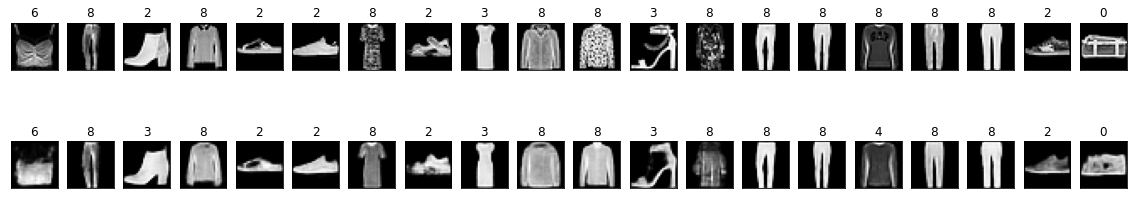

In [10]:
with torch.no_grad():
    encoder = encoder.eval()
    decoder = decoder.eval()

    X_test = None
    y_test = None

    for (x, target) in (valid_loader):
        '''
        if X_test == None:
            X_test = x
            y_test = target
        else:
            X_test = torch.cat((X_test, x), 0)
            y_test = torch.cat((y_test, target), 0)
        '''
        X_test = x
        y_test = target
        break


    if is_cuda:
        X_test = X_test.cuda(cuda)

    #test_batch_size = 10000
    X_test = X_test.resize(VALID_BATCH_SIZE, 1, 28, 28) 

    list_y_test = []
    for item in y_test:
        list_y_test.append(item.item())

    encoded_X_test = encoder(X_test)
    #training_generator_sample.append(encoded_X_test)
    target_list = list_y_test
    n_digits = 20
    decoded_X_test = decoder(encoder(X_test[:n_digits]))

    resized_decoded_X_test = decoded_X_test.resize(n_digits, 1, 28, 28)
    resized_decoded_X_test = resized_decoded_X_test.cuda(cuda)
    label_decoded = classifier(resized_decoded_X_test)
    label_decoded = label_decoded.argmax(dim=1, keepdim=True)
    label_decoded = torch.flatten(label_decoded)

    original_X = X_test[:n_digits]
    resized_original_X = original_X.resize(n_digits, 1, 28, 28)
    resized_original_X = resized_original_X.cuda(cuda)
    target_original_X = classifier(resized_original_X)
    target_original_X = target_original_X.argmax(dim=1, keepdim=True)
    target_original_X = torch.flatten(target_original_X)

    decoded_label_cpu = label_decoded.cpu().detach().numpy()
    decoded_target_original_X = target_original_X.cpu().detach().numpy()
    decoded_X_test_cpu = decoded_X_test.cpu()
    decoded_X_test_cpu = np.reshape(decoded_X_test_cpu.detach().numpy(), [-1, 28, 28]) * 255
    figure = plt.figure(figsize=(20, 4))

    for i in range (n_digits):
        axis = plt.subplot(2, n_digits, i + 1)
        axis.set_title(str(decoded_target_original_X[i]))
        X_test_cpu = X_test.cpu()
        plt.imshow(X_test_cpu[i].reshape(28, 28).detach().numpy())
        plt.gray()
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

        axis = plt.subplot(2, n_digits, i + 1 + n_digits)
        axis.set_title(str(decoded_label_cpu[i]))
        plt.imshow(decoded_X_test_cpu[i])
        plt.gray()
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.show()
    plt.savefig('demo.png')
    plt.close('all')
